# Panorama 360

In [1]:
from src.utils import image_utils
from src.utils import notebook_utils

from src.process import feature_extraction, automatic_ordering, panorama, recursive_panorama
import cv2
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
images = image_utils.load_raw_images("Panorama360_1")
print("load sucess")

load sucess


In [3]:
kp_descs = [feature_extraction.SIFT(img, nfeatures=1000) for img in images.values()]

In [4]:
match_directions = []

for i in range(1, len(kp_descs)):
    bf = cv2.BFMatcher(cv2.NORM_L2)

    kp1, des1 = kp_descs[i]
    kp2, des2 = kp_descs[i - 1]
    
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = image_utils.david_loew_ratio_test(matches)
    
    if len(good_matches) < 4:
        raise Exception
    
    vertical_matches = 0
    horizontal_matches = 0
    
    for match in good_matches:
        pt1 = kp1[match.queryIdx].pt
        pt2 = kp2[match.trainIdx].pt

        delta_x = abs(pt1[0] - pt2[0])
        delta_y = abs(pt1[1] - pt2[1])
        
        if delta_x > delta_y:
            horizontal_matches += 1
        else:
            vertical_matches += 1
            
    if vertical_matches > horizontal_matches:
        match_directions.append("vertical")
    else:
        match_directions.append("horizontal")


In [5]:
match_directions


['vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'horizontal',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'horizontal',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'horizontal',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'horizontal',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'horizontal',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'horizontal',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical',
 'vertical']

In [6]:
subsets = [[0]]
actual_subset = 0


current_direction = match_directions[0]

for i in range(1, len(match_directions)):
    if match_directions[i] == current_direction:
        subsets[actual_subset].append(i)
    else:
        subsets[actual_subset].append(i)
        subsets.append([])
        actual_subset += 1
        
subsets[actual_subset].append(len(match_directions))

In [7]:
import numpy as np
def is_inverted(images: list[np.ndarray]) -> bool:
    """Calcula o quão a esquerda estão os keypoints que deram match de cada uma das pontas do caminho
    para saber se está invertido.
    
    Agora só recebe as imagens e calcula automaticamente os descritores e matches.
    """
    
    # --- Extrair keypoints e descritores para cada imagem ---
    kp_descs = []
    for img in images:
        kp, desc = feature_extraction.SIFT(img)
        kp_descs.append((kp, desc))
    
    # --- Calcular matches entre todas as imagens ---
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches_per_image: dict[int, list[cv2.DMatch]] = {}

    for i in range(len(images)):
        matches_per_image[i] = []
        for j in range(len(images)):
            if i != j and kp_descs[i][1] is not None and kp_descs[j][1] is not None:
                matches = bf.match(kp_descs[i][1], kp_descs[j][1])
                matches_per_image[i].extend(matches)

    # --- Segue a mesma lógica original ---
    begin_path = 0
    keypoints_match_begin = [kp_descs[begin_path][0][m.queryIdx] for m in matches_per_image[begin_path]]

    end_path = len(images) - 1
    keypoints_match_end = [kp_descs[end_path][0][m.queryIdx] for m in matches_per_image[end_path]]

    width_image_begin = images[begin_path].shape[1]
    left_score_begin = sum(1 - (kp.pt[0] / width_image_begin) for kp in keypoints_match_begin)

    width_image_end = images[end_path].shape[1]
    left_score_end = sum(1 - (kp.pt[0] / width_image_end) for kp in keypoints_match_end)

    return left_score_begin > left_score_end

In [8]:
one_direction_panoramas = []
images_list = list(images.values())

for subset in subsets:
    images_subset = []
    for i in subset:
        images_subset.append(images_list[i])
        
    images_subset = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images_subset]
    
    images_subset = [cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) for img in images_subset]
    
    is_inv = is_inverted(images_subset)
    
    if not is_inv:
        images_subset = images_subset[::-1]
    
    panorama = recursive_panorama.recurse_tree(images_subset)
    
    panorama_bgr = cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR)
        
    one_direction_panoramas.append(cv2.rotate(panorama_bgr, cv2.ROTATE_90_COUNTERCLOCKWISE))

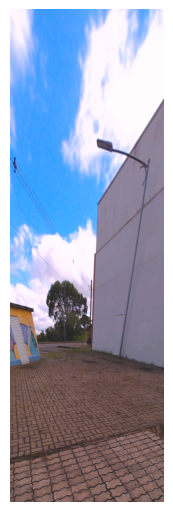

In [15]:
notebook_utils.show_image(one_direction_panoramas[2])